# Backtesting

In this section, we construct a backtest using industry data. More precisely, we use data from Ken French's data library to construct a simple industry momentum return predictor.

The goal of a backtest is to assess the validity of a trading predictor at any point in the past. In particular, it is crucial to avoid any forward-looking bias -- in which information available only after time $t$ is mistakingly used at time $t$. In practice, the predictors are estimated over `rolling` (or `expanding`) windows. We implement rolling window estimation with the `sklearn` `TimeSeriesSplit` object. 

For backtesting, visualisation is very important and we make use of some plotting functions introduced in the Appendix:

In [1]:
from skfin.plot import line, bar, heatmap

## Industry momentum backtest 

The setup for predicting industry returns is the following: 

- the assets are industries; 

- the return forecast $\alpha$ is estimated using rolling-window returns (over $L$ months, $L=12$) preceding a given date; 

-  no `look-ahead bias`: at each date, only information up that date is used; 

- such a strategy goes long past "winners" (industries with higher-than-average returns) and goes short "losers" (industries with lower-than-average returns) $\Rightarrow$ Momentum strategy; 

- this strategy is often implemented by skipping the most recent month to avoid the `1-month reversal" effect`. 

The article "Do Industries Explain Momentum" (1999) by  Moskowitz and Grinblatt  in the  *Journal of Finance* document that indeed there is momentum in industry returns -- past industry returns help predict statistically and economically future industry returns. 

In [2]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import display, Image

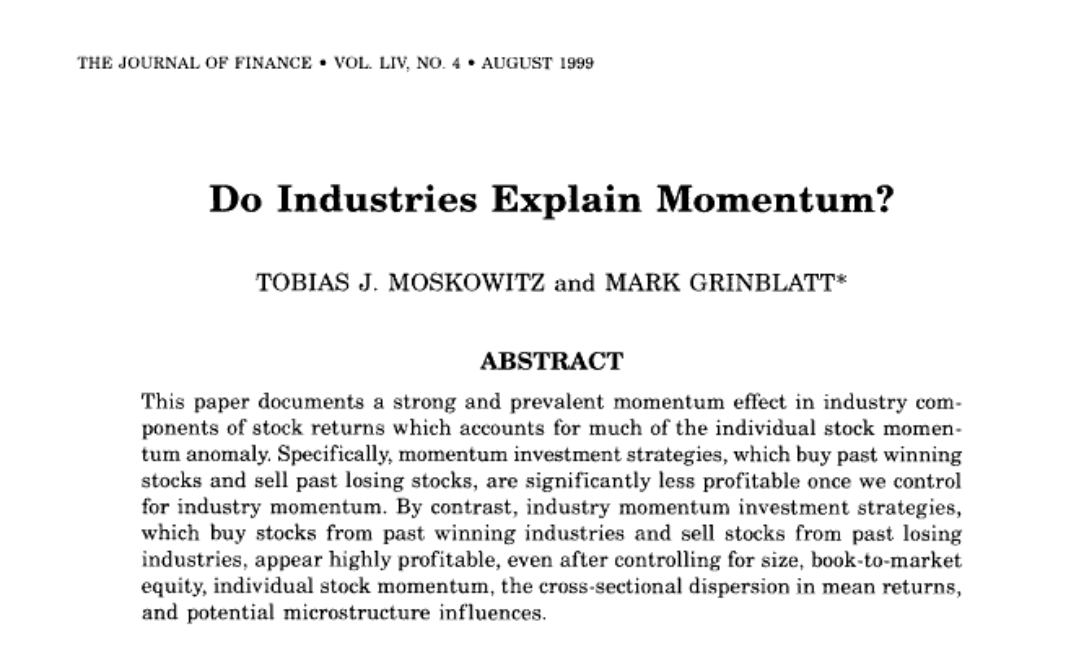

In [3]:
#hide 
display(Image("images/l2_grinblatt_header.png", width=600))

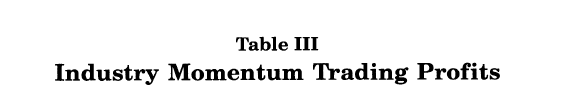

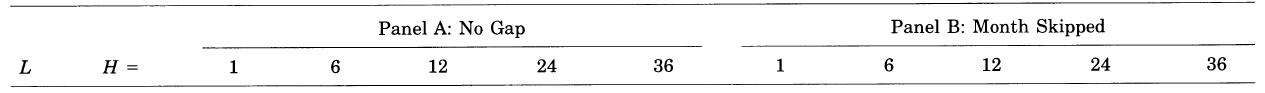

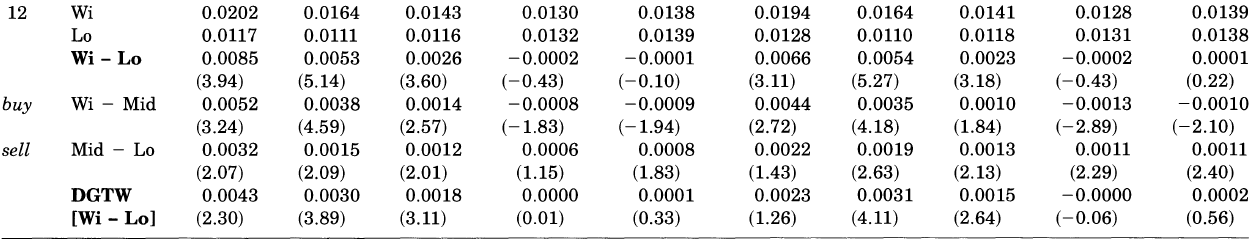

In [4]:
#hide
display(Image("images/l2_grinblatt_table3heading.PNG", width=600))
display(Image("images/l2_grinblatt_table3heading2.PNG", width=800))
display(Image("images/l2_grinblatt_table3.PNG", width=800))

### Industry data

To load the data, we use the function `load_kf_returns` introduce in the `Data` section: 

In [5]:
from skfin.datasets import load_kf_returns

In [6]:
returns_data = load_kf_returns(cache_dir="data", force_reload=True)

INFO:skfin.datasets:loading from external source
INFO:skfin.datasets:saving in cache directory data/12_Industry_Portfolios


Since the Moskowitz-Grinblatt paper was published in August 1999, we will keep the data after 1999 as `out-of-sample` and only use the data before 1999. 

In [7]:
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:'1999']

Time convention:
- holdings $h_t$ and returns $r_t$ are known for period $t$ -- ie. *at the end of period $t$.

- so to compute pnl with forward-looking information, the holdings must only depend on information up to $t-1$

- in practice, we will have

$$ pnl_t = h_{t-1} \times r_t $$

### Backtesting functions

In the next set of helper file, we introduce the main `Bactester` class and the `fit_and_predict` function to run rolling window estimations. 

In [8]:
%%writefile ../skfin/backtesting.py
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.metaestimators import _safe_split


class Backtester:
    def __init__(
        self,
        estimator,
        ret,
        max_train_size=36,
        test_size=1,
        start_date="1945-01-01",
        end_date=None,
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.estimator = estimator
        self.ret = ret[: self.end_date]
        self.cv = TimeSeriesSplit(
            max_train_size=max_train_size,
            test_size=test_size,
            n_splits=1 + len(ret.loc[start_date:end_date]) // test_size,
        )

    def train(self, features, target):
        pred, estimators = fit_predict(
            self.estimator, features, target, self.ret, self.cv, return_estimator=True
        )
        self.estimators_ = estimators
        self.h_ = pred
        if isinstance(pred, pd.DataFrame):
            self.pnl_ = (
                pred.shift(1).mul(self.ret).sum(axis=1)[self.start_date : self.end_date]
            )
        elif isinstance(pred, pd.Series):
            self.pnl_ = pred.shift(1).mul(self.ret)[self.start_date : self.end_date]
        return self


def _fit_predict(estimator, X, y, train, test, return_estimator=False):
    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)
    estimator.fit(X_train, y_train)
    if return_estimator:
        return estimator.predict(X_test), estimator
    else:
        return estimator.predict(X_test)


def fit_predict(
    estimator,
    features,
    target,
    ret,
    cv,
    return_estimator=False,
    verbose=0,
    pre_dispatch="2*n_jobs",
    n_jobs=1,
):
    parallel = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)
    res = parallel(
        delayed(_fit_predict)(
            clone(estimator), features, target, train, test, return_estimator
        )
        for train, test in cv.split(ret)
    )
    if return_estimator:
        pred, estimators = zip(*res)
    else:
        pred = res

    idx = ret.index[np.concatenate([test for _, test in cv.split(ret)])]
    if isinstance(ret, pd.DataFrame):
        cols = ret.columns
        df = pd.DataFrame(np.concatenate(pred), index=idx, columns=cols)
    elif isinstance(ret, pd.Series):
        df = pd.Series(np.concatenate(pred), index=idx)
    else:
        df = None

    if return_estimator:
        return df, estimators
    else:
        return df

Overwriting ../skfin/backtesting.py


In [9]:
from skfin.mv_estimators import MeanVariance
from skfin.backtesting import Backtester

### Scikit-Learn TimeSeriesSplit

In [10]:
from sklearn.model_selection import TimeSeriesSplit

Given that the data is monthly, we re-estimate the model every month. This is done by choosing the parameter `n_splits` in the class `TimeSeriesSplit` as the number of months. 

In [11]:
start_date = "1945-01-01"
test_size = 1
params = dict(max_train_size=36, test_size=test_size, gap=0)
params["n_splits"] = 1 + len(ret.loc[start_date:]) // test_size

cv = TimeSeriesSplit(**params)

More precisely, with `TimeSeriesSplit`:

- the `test` indices are the dates for which the holdings are computed.

- the `train` indices are the date range over which a forecasting model is trained.

- the target will been shifted by $-1$ and `gap` is set to 0. 

- we can estimate batches with `test_size` > 1.

- `n_splits` is determined so that the backtest starts (just) before a certain start date.

In [12]:
for train, test in cv.split(ret):
    break
ret.iloc[train].index[-1].strftime('%Y%m%d'), ret.iloc[test].index[0].strftime('%Y%m%d')

('19441101', '19441201')

## Empiricial results

### Cumulative pnl

We first define two transform functions: 

- `transform_X` computes the main feature  (or `predictor`) as the average of the trailing 12-month returns; 
- `transform_y` is applied on the returns -- here when passed to the mean-variance `MeanVariance` class to compute the covariance matrix; but more generally to serve as a target for predictors with machine-learning. 

In [13]:
transform_X = lambda x: x.rolling(12).mean().values
transform_y = lambda x: x.shift(-1).values
features = transform_X(ret)
target = transform_y(ret)

In [14]:
_h = []
for train, test in cv.split(ret): 
    m = MeanVariance()
    m.fit(features[train], target[train])
    _h += [m.predict(features[test])]
    
cols = ret.columns 
idx = ret.index[np.concatenate([test for _, test in cv.split(ret)])]
h = pd.DataFrame(np.concatenate(_h), index=idx, columns=cols)

Note that the `line` plotting function shows the sharpe ratio "sr" of the strategy. 

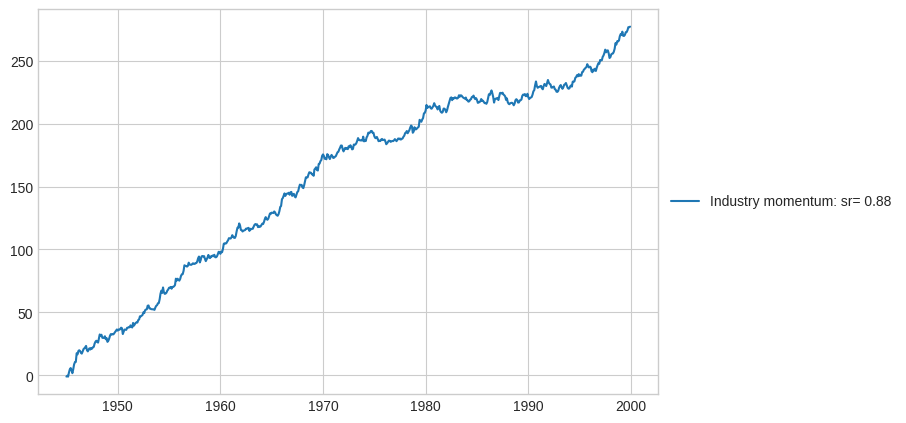

In [15]:
pnl = h.shift(1).mul(ret).sum(axis=1)[start_date:]
line(pnl.rename('Industry momentum'), cumsum=True)

We can also use the `Backtester` class and we test that the two approaches yield the same result.

In [16]:
m = Backtester(estimator=MeanVariance(), ret=ret)
m.train(features, target)
h.equals(m.h_), pnl.equals(m.pnl_)

(True, True)

### Other backtest statistics 

We can also extract information for the estimator -- e.g. in this simple case, recover the covariance matrix fitted by the class `MeanVariance()`.

In [17]:
estimators = m.estimators_

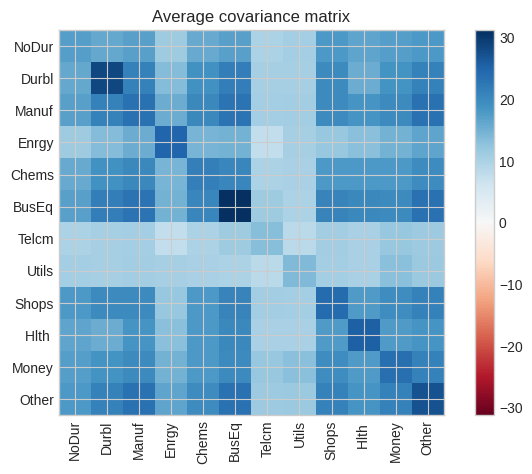

In [18]:
V_mean = pd.DataFrame(sum([m.V_ for m in estimators])/len(estimators), ret.columns, ret.columns)
heatmap(V_mean, title='Average covariance matrix')

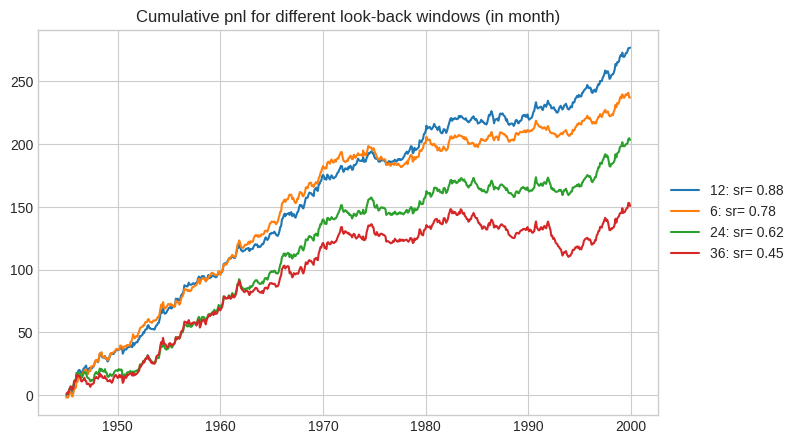

In [19]:
m = Backtester(estimator=MeanVariance(), ret=ret)
pnls = {}
for window in [6, 12, 24, 36]: 
    features_ = ret.rolling(window).mean().values
    m.train(features_, target)
    pnls[window] = m.pnl_
line(pnls, cumsum=True, start_date='1945', title='Cumulative pnl for different look-back windows (in month)')

The following graph shows the `lead-lag sharpe ratio` plot for the industry momentum backtest: 
    
- the horizon "0" (green bar) represents the sharpe ratio of the tradable pnl; 
- the lagged horizons (with positive coordinates) show the performance when the positions are lagged by several months and illustrates the `alpha decay` of the predictor; 
- the lead horizons (with negative coordinates) represent the non-tradable counterfactual performance if the information had been available earlier. 

For `trending` predictors (like the industry momentum backtest), the lead sharpe ratios are very high and the alpha decay is quite fast. For `contrarian` predictors, the lead sharpe ratios are negative. 

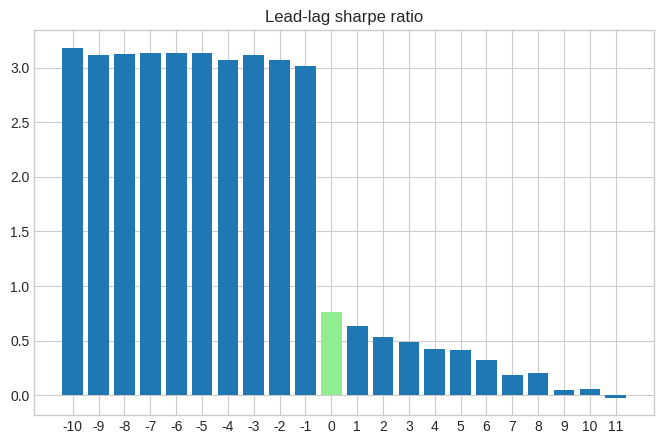

In [20]:
from skfin.metrics import sharpe_ratio
sr = {i: h.shift(1+i).mul(ret).sum(axis=1).pipe(sharpe_ratio) for i in range(-10, 12)}
bar(sr, baseline=0, sort=False, title='Lead-lag sharpe ratio')

The `off-the-top` approach is to remove an asset from the tradable set and check whether the portfolio sharpe ratio decreases (in which case, this asset is a *contributor*) or increases (in which case, this asset is a *detractor*).

In [21]:
pnls_ott = {}
for c in ret.columns:
    ret_ = ret.drop(c, axis=1)
    features_ = transform_X(ret_)
    target_ = transform_y(ret_)
    pnl_ = Backtester(estimator=MeanVariance(), ret=ret_).train(features_, target_).pnl_
    pnls_ott[c] = pnl_.pipe(sharpe_ratio)

pnls_ott["ALL"] = pnl.pipe(sharpe_ratio)

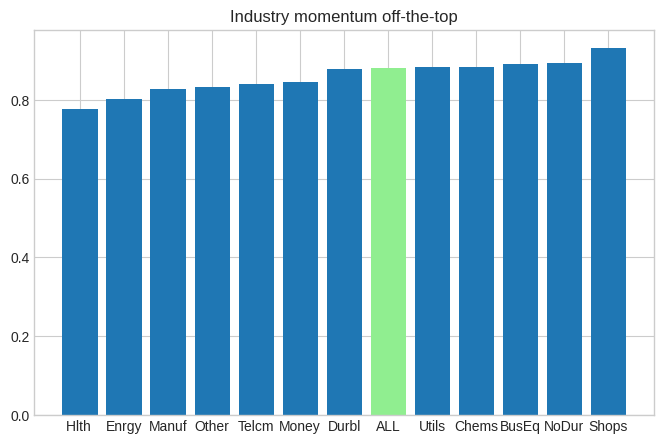

In [22]:
bar(pnls_ott, baseline="ALL", title='Industry momentum off-the-top')